In [ ]:
import numpy as np
import pandas as pd

# metrics

In [ ]:
# ROC AUC
def roc_auc(X, y, classifier):
  pos_proba = np.array([proba[1] for proba in classifier.predict_proba(X)])
  # отсортировать объекты в порядке убывания pos_proba
  index = (-pos_proba).argsort()
  X_sorted = X.iloc[index, :]
  y_sorted = y.iloc[index]
  neg = (y == 0).value_counts()[True]
  pos = (y == 1).value_counts()[True]

  roc_x = []
  roc_y = []
  rx, ry = 0, 0
  pos_sum = 0
  for i, y_value in enumerate(y_sorted):
    if y_value == 0:
      rx += 1/neg
      # auc
      positives = y_sorted[:i] == 1
      if positives.any():
        pos_sum += positives.value_counts()[True]

    if y_value == 1:
      ry += 1/pos
    roc_x.append(rx)
    roc_y.append(ry)
  auc = pos_sum / (pos * neg)
  return roc_x, roc_y, auc

In [ ]:
def nonzero_args_length(func):
  def wrap(*args):
    for arg in args:
      if hasattr(arg, '__len__') and not len(arg):
        return 0
    return func(*args)
  return wrap

class Metrics:
  """ Класс с метриками """
  @staticmethod
  @nonzero_args_length
  def MSE(y_pred, y_true):
    return ((y_true - y_pred) ** 2).mean()

  @staticmethod
  @nonzero_args_length
  def logloss(p_pred, p_true, eps=1e-15):
    p_pred = np.clip(p_pred, eps, 1 - eps)
    return -np.mean(p_true * np.log(p_pred) + (1.0 - p_true) * np.log(1.0 - p_pred))

  @staticmethod
  @nonzero_args_length
  def R2(y_pred, y_true):
    return 1 - Metrics.MSE(y_pred, y_true) / y_true.var()

  @staticmethod
  @nonzero_args_length
  def accuracy(y_pred, y_true):
    true_indexes = (y_pred == y_true)
    return y_pred[true_indexes].size / y_true[true_indexes].size

  @staticmethod
  @nonzero_args_length
  def error_matrix(y_pred, y_true, klass=1):
    kl_cond = (y_true == klass)
    true_cond = y_pred == y_true
    TP = y_pred[true_cond & kl_cond].size
    TN = y_pred[true_cond & ~kl_cond].size
    FP = y_pred[~true_cond & ~kl_cond].size
    FN = y_pred[~true_cond & kl_cond].size
    return np.array([[TP, FP],
                    [FN, TN]])

  @staticmethod
  @nonzero_args_length
  def precision(y_pred, y_true, klass=1):
    ma = Metrics.error_matrix(y_pred, y_true, klass)
    return ma[0, 0] / (ma[0, 0] + ma[0, 1])

  @staticmethod
  @nonzero_args_length
  def recall(y_pred, y_true, klass=1):
    ma = Metrics.error_matrix(y_pred, y_true, klass)
    return ma[0, 0] / (ma[0, 0] + ma[1, 0])

  @staticmethod
  @nonzero_args_length
  def f1_score(y_pred, y_true, klass=1, beta=1):
    return (1 + beta ** 2) * Metrics.precision(y_pred, y_true, klass) * Metrics.recall(y_pred, y_true, klass) / ((beta ** 2) * Metrics.precision(y_pred, y_true, klass) + Metrics.recall(y_pred, y_true, klass))

# dependencies

In [ ]:
def recast_args(*, n: int = 0, originals: list = (), target=np.array):
  """ Cast first n arguments to given type """
  def _decorator(func):
    def wrapper(self, *args, **kwargs):
      recasted = [target(arg) if type(arg) in originals else arg for arg in args[:n]]
      recasted.extend(args[n:])
      return func(self, *recasted, **kwargs)
    return wrapper
  return _decorator

In [ ]:
class DefDict(dict):
  def __getitem__(self, key):
    if key not in self.keys():
      self[key] = 0
    return self.get(key)


class ClassCounter(DefDict):
  """ Счетчик классов """
  def __init__(self, iterable):
    super().__init__()
    self.__size = len(iterable)
    for item in iterable:
      self[item] += 1

  @property
  def most_frequent(self):
    return max(self, key=self.get)
  
  @property
  def values(self):
    return np.array(list(super().values()))
    # return np.array([self[key] for key in sorted(self.keys())])     # если вдруг понадобятся отсортированные по классам
  
  @property
  def proba(self):
    """ Вероятности по каждому классу """
    return DefDict({k: v / self.__size for k, v in self.items()})


In [ ]:
class Criteria:
  """ Набор критериев информативности """
  @staticmethod
  def variance(values: np.array):
    """ Дисперсия """    
    return values.var() if values.size else 0
  
  @staticmethod
  def gini(values: np.array):
    """ Критерий Джини """
    classes = ClassCounter(values).values
    p = classes / classes.sum()
    return 1 - (p ** 2).sum() if p.size else 0
  
  @staticmethod
  def entropy(values: np.array, eps=1e-15):
    """ Энтропия Шеннона """
    classes = ClassCounter(values).values
    p = np.clip(classes / classes.sum(), eps, 1 - eps)
    return -np.sum(p * np.log2(p))

In [ ]:
class Predictor:
  """ Набор функций получения предсказаний из листа 
  return types:
    для регрессии возвращаемое значение должно быть float
    для классификации возвращаемое значение должно быть dict с вероятностями классов
  """
  def __init__(self, rs=None):
    self.rs = rs

  @staticmethod
  def regress_average_mean(values):
    """ Функция усреднения предсказаний для регрессии
    :param type - np.array[float]
    :return type float
    """
    return np.mean(values)

  def regress_average_median(values):
    """ Функция усреднения предсказаний для регрессии
    :param type - np.array[float]
    :return type float
    """
    return np.median(values)

  @staticmethod
  def class_average_mean(values):
    """ Функция усреднения предсказаний для классификации
    :param type - np.array[dict(klass: probability)]
    :return type dict(klass: probability)
    """
    avg_proba = DefDict()
    for element in values:
      for klass, proba in element.items():
        avg_proba[klass] += proba
    return {kl: pr / values.size for kl, pr in avg_proba.items()}

  @staticmethod
  def regress_mean(leaf_values, data=None):
    return lambda x: np.mean(leaf_values)
  
  @staticmethod
  def regress_median(leaf_values, data=None):
    return lambda x: np.median(leaf_values)
  
  @staticmethod
  def class_proba(leaf_values, true_value):
    """ Вероятности классов """
    return lambda x: ClassCounter(leaf_values).proba

  def regress_linear(self, leaf_values, data):
    """ Линейная модель внутри листа для регрессии """
    # get statistics and normalize data
    # mins = data.min(axis=0)
    # maxs = data.max(axis=0)
    # X = (data - mins) / (maxs - mins)

    # get statistics and standardize data
    means = data.mean(axis=0)
    stds = data.std(axis=0)
    X = (data - means) / stds     # из-за малого кол-ва объектов в листе тут может быть Division by zero
    X = np.insert(X, 0, 1, axis=1)   # add intercept
    # fit
    lm = LinearModel(model_type='regress')
    lm.fit(X, leaf_values, eta=0.1, iterations=250, random_state=self.rs)
    # тут можно посмотреть на данные внутри листа
    # print(X.shape[1], lm.W)
    # plt.scatter(X[:, 1:], leaf_values)
    # plt.plot(X[:, 1:], lm.predict(X))
    # plt.show()

    def prepare_predict(x):
      x = x.copy()
      # x = (x - mins) / (maxs - mins)    # normalize
      x = (x - means) / stds      # standardize
      x = np.insert(x, 0, 1)
      return lm.predict(x)
    return prepare_predict

  def class_linear(self, leaf_values, data):
    """ Линейная модель внутри листа для классификации """
    # get statistics and normalize data
    # mins = data.min(axis=0)
    # maxs = data.max(axis=0)
    # X = (data - mins) / (maxs - mins)

    # get statistics and standardize data
    means = data.mean(axis=0)
    stds = data.std(axis=0)
    X = (data - means) / stds     # из-за малого кол-ва объектов в листе тут может быть Division by zero
    X = np.insert(X, 0, 1, axis=1)   # add intercept
    # fit
    lm = LinearModel(model_type='class')
    lm.fit(X, leaf_values, eta=0.1, iterations=250, random_state=self.rs)

    def prepare_predict(x):
      x = x.copy()
      # x = (x - mins) / (maxs - mins)    # normalize
      x = (x - means) / stds      # standardize
      x = np.insert(x, 0, 1)
      p = lm.predict_proba(x)
      return {0: 1 - p, 1: p}
    return prepare_predict

# linear

In [ ]:
class LinearModel:
  def __init__(self, **kwargs):
    self.model_type = kwargs.get('model_type', None)
    if not self.model_type:
      raise ValueError('`model_type` is a required parameter.')
    elif self.model_type not in ['regress', 'class']:
      raise ValueError('`model_type` parameter can be `regress` or `class`')
    self.__calc_error = self.__mse if self.model_type == 'regress' else self.__logloss

    self.errors = []
    self.W = None
  
  @staticmethod
  def __mse(y_pred, y_true):
      """ Calculate MSE """
      return (y_true - y_pred).mean() ** 2

  @staticmethod
  def __logloss(y_pred, y_true, eps=1e-15):
      y_pred = np.clip(y_pred, eps, 1 - eps)
      return -np.mean(y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred))

  @staticmethod
  def __sigmoid(z):
      return 1 / (1 + np.exp(-z))

  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)
  def fit(self, X, y_true, **kwargs):
    """ Fit the linear model with SGD """
    n = X.shape[0]
    # read parameters
    eta = kwargs.pop('eta', 1e-4)
    eps = kwargs.pop('eps', 1e-8)
    max_iterations = kwargs.pop('max_iterations', 100)
    L1 = kwargs.pop('L1', 0)        # L1 regularization
    L2 = kwargs.pop('L2', 0)        # L2 regularization
    batch_type = kwargs.get('batch_type', 'random')
    batch_size = kwargs.get('batch_size', n)
    rs = kwargs.get('random_state', None)
    self.rng = np.random.default_rng(rs)
    if not batch_size:
      print(n)
      raise ValueError('`batch_size` cannot be 0')
    silent = kwargs.get('silent', True)
    
    # fit
    self.W = np.zeros(X.shape[1])
    n_batch = n // batch_size if n % batch_size == 0 else n // batch_size + 1
    # n_batch = n // batch_size if n % batch_size != 0 else n // batch_size + 1
      
    if not silent:
      print(f'Objects: {n}\nLearning rate: {eta}\nInitial weights: {self.W}\n' \
        f'Batch type: {batch_type}; batch size: {batch_size}; total batches: {n_batch}')
    
    iter = 0
    norm_delta = np.inf
    while (norm_delta > eps) and (iter < max_iterations):
      for batch in range(n_batch):      # при n_batch = 1 получаются глюки
        if batch_size and (batch_type == 'random'):
          sample_index = self.rng.integers(X.shape[0], size=batch_size)
          X_batch = X[sample_index]
          y_batch = y_true[sample_index]
        else:
          start = batch_size * batch
          end =  batch_size * (batch + 1)
          X_batch = X[start:end]
          y_batch = y_true[start:end]
        
        # calc and append error
        y_pred = self.predict(X)
        err = self.__calc_error(y_pred, y_true)
        self.errors.append(err)
                
        # iterate gradient
        y_batch_pred = X_batch @ self.W
        dQ = 1 / y_batch.shape[0] * X_batch.T @ (y_batch_pred - y_batch)
        dReg = L1 * np.sign(self.W) + L2 * self.W
        self.W -= eta * (dQ + dReg)
        norm_delta = np.linalg.norm(self.W, ord=1)

      iter += 1
      if (iter == 1 or iter % (max_iterations / 10) == 0) and not silent:
        print(f'Iteration: {iter:4d} | Loss = {round(err, 5)}')
        
    if not silent:
      print(f'Iterations: {iter:4d}  | W = {self.W} | Loss = {round(err, 5)}')
          
  def predict_proba(self, X):
    predict = X @ self.W
    if self.model_type == 'class':
      return self.__sigmoid(predict)
    return predict

  def predict(self, X, threshold=0.5):
    predict = self.predict_proba(X)
    if self.model_type == 'class':
      return np.array([int(item > threshold) for item in predict])
    return predict

  def error(self, y_pred, y_true):
    return self.__calc_error(y_true, y_pred)

# basic classes

In [ ]:
class Leaf:
  """ Класс листа """
  def __init__(self, data, values, predict_method):
    self.data = data                        # набор исходных признаков в листе
    self.values = values                    # набор целевых значений в листе
    self.predict_method = predict_method    # функция, возвращающая предсказание листа (в простейшем случае возвращает константу)

In [ ]:
class Node:
  """ Класс узла """
  def __init__(self, index, threshold, true_branch, false_branch):
    self.index = index                # feature index
    self.threshold = threshold        # condition threshold value
    self.true_branch = true_branch    # branch that match the condition
    self.false_branch = false_branch  # branch that does not match the condition

In [ ]:
class Ensemble:
  def __init__(self, **kwargs):
    # basic ensemble parameters
    self.ensemble = []
    self.bootstraps = []
    self.weights = []
    self.BasicTree = kwargs.get('basic_tree_class')
    self.basic_tree_params = kwargs.get('basic_tree_params', {})

# decision tree

In [ ]:
class DecisionTree():
  def __init__(self, **kwargs):
    """
    :param criteria - функция критерия информативности (impurity function)
    :param predictor - функция получения предсказаний из листа (см. описание класса Predictor)
    """
    self.criteria = kwargs.get('criteria')      # критерий информативности
    self.predictor = kwargs.get('predictor')    # функция расчета предсказаний в листе

    self.__leafs = 0
    self.__max_leafs = np.inf
    self.__depth = 0
    self.tree = None

  def iter_average(self, values):
    """ Генератор среднего между текущим и следующим значением в выборке """
    iterator = iter(values)
    try:      
      elem = next(iterator)
      next_elem = next(iterator)
      while next_elem:
        yield np.mean(elem + next_elem)   # для 2ух значений mean и median одинаковые, так что тут смысла указывать функцию немного. разве что можно извращаться со средним гармоническим итп
        elem = next_elem
        next_elem = next(iterator)
    except StopIteration:
      pass

  def choice_features(self, features_count):
    """ Генерация индексов признаков для разделения подпространств """
    return self.rng.choice(features_count, size=features_count, replace=False)    # заглушка "от дурака". Реализация в потомках

  def gain(self, left_values, right_values, root_criteria):
    """ Расчет информационного прироста """
    p = left_values.shape[0] / (left_values.shape[0] + right_values.shape[0])
    return root_criteria - p * self.criteria(left_values) - (1 - p) * self.criteria(right_values)

  @staticmethod
  def split(data, values, column_index, threshold):
    """ Разбиение датасета в узле """
    condition = data[:, column_index] <= threshold
    true_data = data[condition]
    false_data = data[~condition]
    true_values = values[condition]
    false_values = values[~condition]
    return true_data, false_data, true_values, false_values

  def search_best_split(self, data, values, **kwargs):
    """ Нахождение наилучшего разбиения на текущем уровне """
    min_samples_leaf = kwargs.get('min_samples_leaf', None)

    root_criteria = self.criteria(values)
    best_gain = 0
    best_threshold = None
    best_index = None

    # выбор случайных признаков на уровне постановки вопросов
    features_indexes = kwargs.get('features')
    if features_indexes == 'choice_on_split':
      features_indexes = self.choice_features(data.shape[1])      # выбираем случайные признаки

    for index in features_indexes:
      # NaN processing
      clean_data_index = ~np.isnan(data[:, index])
      clean_data = data[clean_data_index]

      unique_thresholds = np.unique(clean_data[:, index])
      for threshold in self.iter_average(unique_thresholds):
        # ask question and split data
        true_data, false_data, true_values, false_values = self.split(clean_data, values, index, threshold)

        # skip if leaf length < min_samples_leaf
        if min_samples_leaf and ((true_data.shape[0] < min_samples_leaf) or (false_data.shape[0] < min_samples_leaf)):
          continue
        
        current_gain = self.gain(true_values, false_values, root_criteria) * clean_data.shape[0] / data.shape[0]
        # store best result
        if current_gain > best_gain:
          best_gain, best_threshold, best_index = current_gain, threshold, index
          true_data = np.append(true_data, data[~clean_data_index], axis=0)
          false_data = np.append(false_data, data[~clean_data_index], axis=0)

    return best_gain, best_threshold, best_index

  def build_tree(self, data, values, **kwargs):
    """ Построение дерева """
    max_depth = kwargs.get('max_depth', np.inf)
    depth = kwargs.pop('depth', None)
    gain_eps = kwargs.get('gain_eps', 0)
    self.__depth = max(self.__depth, depth)

    gain, threshold, index = self.search_best_split(data, values, **kwargs)
    if (gain <= gain_eps) or (depth == max_depth) or (self.__leafs + 2 > self.__max_leafs - self.__depth):     # +2 потому что узел обязан иметь два потомка, -depth чтобы зарезервировать места для листов в false-ветке
      self.__leafs += 1
      leaf_predict_method = self.predictor(values, data)
      return Leaf(data, values, leaf_predict_method)
    # split data
    true_data, false_data, true_values, false_values = self.split(data, values, index, threshold)    
    true_branch = self.build_tree(true_data, true_values, depth=depth + 1, **kwargs)      # recursive build true branch
    false_branch = self.build_tree(false_data, false_values, depth=depth + 1, **kwargs)   # recursive build false branch
    return Node(index, threshold, true_branch, false_branch)

  # без рекаста всплывает KeyError при индексации по условию в search_best_split(), потому что pandas имеет другой синтаксис обращений по индексу
  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)
  def fit(self, data, values, **kwargs):
    """ Построение дерева
    :param features - используемые признаки. Можно задать списком с индексами признаков, также допустимо `choice_on_start`, `choice_on_split`,
                      в остальных случаях (по умолчанию) - используются все признаки
    :param min_samples_leaf - минимальное кол-во объектов в листе
    :param max_depth - максимальный уровень дочерних элементов дерева
    :param gain_eps - порог прироста информации, ниже которого происходит прекращение наращивания дерева
    :param max_leafs - максимальное кол-во листьев в дереве. ! Их может оказаться сильно меньше !
    """
    if {'depth'}.intersection(kwargs.keys()):
      raise ValueError('Invalid parameters')
    min_samples_leaf = kwargs.get('min_samples_leaf', 1)
    if ('linear' in self.predictor.__name__) and (min_samples_leaf == 1):
      raise ValueError('min_samples_leaf cannot be 1 with linear leaf predictor.')
      
    rs = kwargs.get('random_state', None)
    self.rng = np.random.default_rng(rs)

    # reinitialize basic tree parameters
    self.__max_leafs = kwargs.pop('max_leafs', np.inf)
    self.__leafs = 0
    self.__depth = 0

    # выбор случайных признаков для обучения на старте обучения
    features_indexes = kwargs.pop('features', range(data.shape[1]))
    if (features_indexes == 'choice_on_start'):
      features_indexes = self.choice_features(data.shape[1])      # выбираем случайные признаки
    # build tree
    self.tree = self.build_tree(data, values, depth=0, features=features_indexes, **kwargs)

  def classify(self, obj, node):
    """ Обход дерева вглубь в поиске предсказания """
    if isinstance(node, Leaf):
      return node.predict_method(obj)    
    node = node.true_branch if obj[node.index] <= node.threshold else node.false_branch   # сравнение признака объекта по условию в узле и проход к следующему узлу
    return self.classify(obj, node)
  
  @property
  def leafs(self):
    return self.__leafs
  
  @property
  def depth(self):
    return self.__depth

In [ ]:
class RegressDecisionTree(DecisionTree):
  def __init__(self, **kwargs):
    kw = {}
    kw['criteria'] = kwargs.get('criteria', Criteria.variance)
    kw['predictor'] = kwargs.get('predictor', Predictor.regress_mean)    # функция расчета предсказаний в листе
    super().__init__(**kw)

  def choice_features(self, features_count):
    size = np.ceil(features_count / 3).astype(np.int64)
    return self.rng.choice(features_count, size=size, replace=False)

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, weight=1):
    """ Предсказание значений для набора объектов """
    return np.array([self.classify(obj, self.tree) for obj in data]) * weight

In [ ]:
class ClassDecisionTree(DecisionTree):
  def __init__(self, **kwargs):
    kw = {}
    kw['criteria'] = kwargs.get('criteria', Criteria.gini)
    kw['predictor'] = kwargs.get('predictor', Predictor.class_proba)    # функция расчета предсказаний в листе
    super().__init__(**kw)

  def choice_features(self, features_count):
    size = np.ceil(np.sqrt(features_count)).astype(np.int64)
    return self.rng.choice(features_count, size=size, replace=False)

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict_proba(self, data, weight=1):
    """ Предсказание взвешенной вероятности классов для набора объектов """
    return np.array([{k: v * weight for k, v in self.classify(obj, self.tree).items()} for obj in data])
  
  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, weight=1):
    """ Предсказание значений для набора объектов """
    return np.array([int(max(probas, key=probas.get)) for probas in self.predict_proba(data, weight)])

# boosted decision tree

In [ ]:
class BoostedRegressTree(Ensemble):
  def __init__(self, **kwargs):
    kwargs['basic_tree_class'] = kwargs.get('basic_tree_class', RegressDecisionTree)
    super().__init__(**kwargs)

  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)
  def fit(self, data, values, **kwargs):
    """ Бустинг дерева - регрессия
    :param trees - кол-во деревьев
    :param features - способ отбора признаков: list / 'choice_on_start' / 'choice_on_split'

    :Параметры модели
      :param min_samples_leaf - минимальное кол-во объектов в листе: default - 5 для регрессии, 1 для классификации
      :param max_depth - максимальный уровень дочерних элементов исходного дерева
      :param boost_depth - максимальный уровень дочерних элементов деревьев бустинга
      :param gain_eps - порог прироста информации, ниже которого происходит прекращение наращивания дерева
      :param max_leafs - максимальное кол-во листьев в дереве. ! Их может оказаться сильно меньше !
      :param random_state
    """
    # read params
    rs = kwargs.pop('random_state', None)
    self.rng = np.random.default_rng(rs)    
    trees = kwargs.pop('trees', 3)
    features = kwargs.pop('features', 'choice_on_split')
    min_samples_leaf = kwargs.pop('min_samples_leaf', 1)
    self.eta = kwargs.pop('eta', 0.2)
    max_depth = kwargs.pop('max_depth', np.inf)
    boost_depth = kwargs.pop('boost_depth', np.inf)

    # сгенерировать бутстрапированные выборки
    target = np.zeros(values.shape, dtype=np.float64)
    self.bootstraps = self.rng.integers(data.shape[0], size=(trees, data.shape[0]))
    # построение деревьев
    for i in range(trees):
      bootstrap_X = data[self.bootstraps[i], :]
      bootstrap_t = values[self.bootstraps[i]] - target[self.bootstraps[i]]

      # построение дерева
      dtree = self.BasicTree(**self.basic_tree_params)      
      dtree.fit(bootstrap_X, bootstrap_t, max_depth=boost_depth if i else max_depth,
                features='choice_on_split', min_samples_leaf=min_samples_leaf, random_state=rs, **kwargs)
      self.ensemble.append(dtree)
      target = target + self.eta * dtree.predict(data)
    
  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, weight=1):
    """ Предсказание значения """
    return self.eta * weight * np.sum([tree.predict(data) for tree in self.ensemble], axis=0)

In [ ]:
class BoostedClassTree(Ensemble):
  def __init__(self, **kwargs):
    kwargs['basic_tree_class'] = kwargs.get('basic_tree_class', ClassDecisionTree)
    super().__init__(**kwargs)
    self.classes_count = 2

  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)
  def fit(self, data, values, **kwargs):
    """ Бустинг дерева - классификация
    :param trees - кол-во деревьев
    :param features - способ отбора признаков: list / 'choice_on_start' / 'choice_on_split'

    :Параметры модели
      :param min_samples_leaf - минимальное кол-во объектов в листе: default - 5 для регрессии, 1 для классификации
      :param max_depth - максимальный уровень дочерних элементов исходного дерева
      :param boost_depth - максимальный уровень дочерних элементов деревьев бустинга
      :param gain_eps - порог прироста информации, ниже которого происходит прекращение наращивания дерева
      :param max_leafs - максимальное кол-во листьев в дереве. ! Их может оказаться сильно меньше !
      :param random_state
    """
    # read params
    rs = kwargs.pop('random_state', None)
    self.rng = np.random.default_rng(rs)    
    trees = kwargs.pop('trees', 3)
    features = kwargs.pop('features', 'choice_on_split')
    min_samples_leaf = kwargs.pop('min_samples_leaf', 1)
    max_depth = kwargs.pop('max_depth', np.inf)
    boost_depth = kwargs.pop('boost_depth', np.inf)

    self.classes_count = np.unique(values).size
    # сгенерировать бутстрапированные выборки
    self.bootstraps = self.rng.integers(data.shape[0], size=(trees, data.shape[0]))
    # построение деревьев
    for i in range(trees):
      bootstrap_X = data[self.bootstraps[i], :]
      bootstrap_t = values[self.bootstraps[i]]

      # построение дерева
      dtree = self.BasicTree(**self.basic_tree_params)
      dtree.fit(bootstrap_X, bootstrap_t, max_depth=boost_depth if i else max_depth,
                features='choice_on_split', min_samples_leaf=min_samples_leaf, random_state=rs, **kwargs)

      # проверка ошибок
      predicts = dtree.predict(data)
      error_rate = (predicts != values).sum() / values.size
      # если дерево слишком много ошибается - отбрасываем его
      if error_rate >= 1 - 1 / self.classes_count:
        continue
      self.ensemble.append(dtree)
      # Вычислим вес для дерева
      weight = 0.5 * np.log((1 - error_rate) / error_rate)
      self.weights.append(weight)
  
  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)
  def predict_proba(self, data, weight=1):
    """ Предсказание вероятностей """
    predicts = np.zeros(shape=(data.shape[0], self.classes_count))    # init predicts with zeros
    for tree, w in zip(self.ensemble, self.weights):
      ind = tree.predict(data)
      predicts[range(data.shape[0]), ind] += w
    probas = np.apply_along_axis(lambda row: row / row.sum(), 1, predicts)
    # return np.array([dict(np.vstack([np.arange(self.classes_count, dtype=np.int64), pred]).T) for pred in probas])
    return np.array([dict(zip(np.arange(self.classes_count), pred)) for pred in probas])

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, weight=1):
    """ Предсказание класса """
    predicts = np.zeros(shape=(data.shape[0], self.classes_count))    # init predicts with zeros
    for tree, w in zip(self.ensemble, self.weights):
      ind = tree.predict(data)
      predicts[range(data.shape[0]), ind] += w

    return np.argmax(predicts, axis=1)


# random forest (with boost support)

In [ ]:
class RandomForest(Ensemble):
  # без рекаста всплывает KeyError при разделении на бутстрап выборки, потому что pandas имеет другой синтаксис обращений по индексу
  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def fit(self, data, values, **kwargs):
    """ Построение ансамбля деревьев
    :param trees - кол-во деревьев
    :param features - способ отбора признаков: list / 'choice_on_start' / 'choice_on_split'

    :Параметры модели
      :param min_samples_leaf - минимальное кол-во объектов в листе: default - 5 для регрессии, 1 для классификации
      :param max_depth - максимальный уровень дочерних элементов дерева
      :param boost_depth - максимальный уровень дочерних элементов деревьев бустинга
      :param gain_eps - порог прироста информации, ниже которого происходит прекращение наращивания дерева
      :param max_leafs - максимальное кол-во листьев в дереве. ! Их может оказаться сильно меньше !
      :param boost_metric - метрика для измерения весов деревьев
      :param boost_data - данные для измерения метрики: Tuple[X, y]
      :param random_state
    """
    # read params
    rs = kwargs.get('random_state', None)
    self.rng = np.random.default_rng(rs)
    trees = kwargs.pop('trees', 3)
    if 'Boosted' in self.BasicTree.__name__:
      kwargs['trees'] = kwargs.pop('boost', 3)
    features = kwargs.pop('features', 'choice_on_split')
    min_samples_leaf = kwargs.pop('min_samples_leaf', 5)    # рекомендовано 5 для регрессии 1 для классификации
    boost_metric = kwargs.get('boost_metric', None)
    boost_data = kwargs.get('boost_data', None)
    if boost_metric:
      metric_X = boost_data[0]
      metric_y = boost_data[1]

    # сгенерировать бутстрапированные выборки
    self.bootstraps = self.rng.integers(data.shape[0], size=(trees, data.shape[0]))
    # построение деревьев
    for i in range(trees):
      bootstrap_X = data[self.bootstraps[i], :]
      bootstrap_y = values[self.bootstraps[i]]
      # построение дерева
      if 'Boosted' in self.BasicTree.__name__:
        dtree = self.BasicTree(basic_tree_params=self.basic_tree_params)
      else:
        dtree = self.BasicTree(**self.basic_tree_params)
      dtree.fit(bootstrap_X, bootstrap_y, features='choice_on_split', min_samples_leaf=min_samples_leaf, **kwargs)
      self.ensemble.append(dtree)

      # считаем метрику каждого дерева
      if boost_metric:
        metric_pred = dtree.predict(metric_X)
        metric_value = boost_metric(metric_pred, metric_y)
      else:
        metric_value = 1
      self.weights.append(metric_value)

    # переводим метрики в веса
    self.weights = np.array(self.weights)
    self.weights = self.weights * self.weights.size / self.weights.sum()    # classic weights
    # self.weights = 1 / self.weights    # boost weights

    # расчет Out-of-Bag
    return self._calc_out_of_bag(data, values)

In [ ]:
class RegressRandomForest(RandomForest):
  """ Случайный лес - регрессия """
  def __init__(self, **kwargs):
    kwargs['basic_tree_class'] = kwargs.get('basic_tree_class', RegressDecisionTree)
    super().__init__(**kwargs)
    self.error_getter = kwargs.get('error', Metrics.MSE)       # функция ошибки для Out-of-Bag

  def _calc_out_of_bag(self, data, values):
    """ Расчет Out-of-Bag """
    # маска объектов, участвовавших в обучении деревьев
    used_data_mask = np.array([[index in bootstrap for index in range(data.shape[0])] for bootstrap in self.bootstraps]).T
    # считаем предсказания каждого дерева, потом считаем ошибку по массиву предсказаний нужных деревьев для каждого элемента, значения суммируем
    tree_predicts = np.array([tree.predict(data, weight) for tree, weight in zip(self.ensemble, self.weights)]).T
    # общая ошибка среди нужных деревьев по элементу:
    return np.array([self.error_getter(predict[mask], value) for predict, mask, value in zip(tree_predicts, ~used_data_mask, values) if mask.any()]).sum()

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, predict_average=Predictor.regress_average_mean):
    """ Предсказание значения по лесу """
    tree_predicts = np.array([tree.predict(data, weight) for tree, weight in zip(self.ensemble, self.weights)])
    return np.array([predict_average(pred_variants) for pred_variants in tree_predicts.T])

In [ ]:
class ClassRandomForest(RandomForest):
  """ Случайный лес - классификация """
  def __init__(self, **kwargs):
    kwargs['basic_tree_class'] = kwargs.get('basic_tree_class', ClassDecisionTree)
    super().__init__(**kwargs)
    self.error_getter = kwargs.get('error', Metrics.MSE)       # функция ошибки для Out-of-Bag

  def _calc_out_of_bag(self, data, values):
    """ Расчет Out-of-Bag """
    # маска объектов, участвовавших в обучении деревьев
    used_data_mask = np.array([[index in bootstrap for index in range(data.shape[0])] for bootstrap in self.bootstraps]).T
    # считаем предсказания каждого дерева, потом считаем ошибку по массиву предсказаний нужных деревьев для каждого элемента, значения суммируем
    # вероятность оказаться ПРАВИЛЬНЫМ классом
    tree_predicts = np.array([[DefDict(proba)[values[index]] for index, proba in enumerate(tree.predict_proba(data, weight))] for tree, weight in zip(self.ensemble, self.weights)]).T
    # за ошибку классификации здесь принимается функция ошибки от предсказанной и истинной вероятности правильного класса
    # общая ошибка среди нужных деревьев по элементу:
    return np.array([self.error_getter(predict[mask], 1) for predict, mask in zip(tree_predicts, ~used_data_mask) if mask.any()]).sum()

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict_proba(self, data, predict_average=Predictor.class_average_mean):
    """ Предсказание вероятности по лесу """
    tree_predicts = np.array([tree.predict_proba(data, weight) for tree, weight in zip(self.ensemble, self.weights)])
    return np.array([predict_average(pred_variants) for pred_variants in tree_predicts.T])

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, predict_average=Predictor.class_average_mean):
    """ Предсказание значения по лесу """
    return np.array([max(probas, key=probas.get) for probas in self.predict_proba(data, predict_average)])

# make data

In [ ]:
# debug
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# генератор нелинейной регрессии. стянуто с хабра: https://habr.com/ru/company/ods/blog/322534/
# и допилено: rs = random_state
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, rs):
    rng = np.random.default_rng(rs)
    X = rng.random(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + rng.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

In [ ]:
# generate classification task
cl_X, cl_y = make_classification(n_samples=500, n_features=2, n_informative=2, n_classes=2, n_redundant=0, n_clusters_per_class=1, random_state=5)
cl_X_train, cl_X_valid, cl_y_train, cl_y_valid = train_test_split(cl_X, cl_y, test_size=0.3, random_state=1)

# generate regression task
reg_X, reg_y = generate(500, 0.15, 12)
reg_X_train, reg_X_valid, reg_y_train, reg_y_valid = train_test_split(reg_X, reg_y, test_size=0.3, random_state=1)

# linear test

In [ ]:
lm = LinearModel(model_type='class')
lm.fit(cl_X_train, cl_y_train)
lm_train_pred = lm.predict(cl_X_train)
lm_valid_pred = lm.predict(cl_X_valid)

In [ ]:
print(Metrics.f1_score(lm_train_pred, cl_y_train))
print(Metrics.f1_score(lm_valid_pred, cl_y_valid))

0.8084112149532711
0.7872340425531915


# decision tree test

In [ ]:
classifier = ClassDecisionTree()
classifier.fit(cl_X_train, cl_y_train)

train_pred = classifier.predict(cl_X_train)
valid_pred = classifier.predict(cl_X_valid)
print(Metrics.f1_score(train_pred, cl_y_train))
print(Metrics.f1_score(valid_pred, cl_y_valid))

0.9913544668587896
0.9419354838709678


0.8925755773343028
0.896775629067892


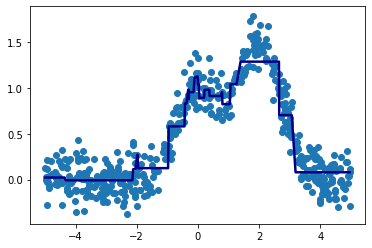

In [ ]:
regressor = RegressDecisionTree()
regressor.fit(reg_X_train, reg_y_train)

train_pred = regressor.predict(reg_X_train)
valid_pred = regressor.predict(reg_X_valid)
print(Metrics.R2(train_pred, reg_y_train))
print(Metrics.R2(valid_pred, reg_y_valid))

plt.scatter(reg_X, reg_y)
plt.plot(reg_X, regressor.predict(reg_X), color='darkblue', lw=2.5)
plt.show()

# random forest test

In [ ]:
classifier = ClassRandomForest()
cl_oob = classifier.fit(cl_X_train, cl_y_train, max_depth=3, random_state=24)

train_pred = classifier.predict(cl_X_train)
valid_pred = classifier.predict(cl_X_valid)
print(f'OOB = {cl_oob}')
print(Metrics.f1_score(train_pred, cl_y_train))
print(Metrics.f1_score(valid_pred, cl_y_valid))

OOB = 8.679878890636191
0.9772727272727273
0.9299363057324841


OOB = 9.501750823812824
0.8990534123444642
0.9045428958625248


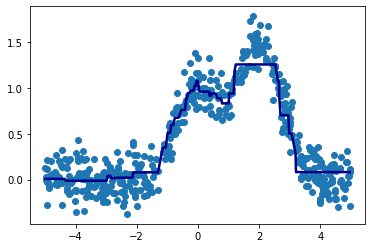

In [ ]:
regressor = RegressRandomForest()
reg_oob = regressor.fit(reg_X_train, reg_y_train, max_depth=9, boost_metric=Metrics.R2, boost_data=(reg_X_train, reg_y_train), random_state=24)

train_pred = regressor.predict(reg_X_train)
valid_pred = regressor.predict(reg_X_valid)
print(f'OOB = {reg_oob}')
print(Metrics.R2(train_pred, reg_y_train))
print(Metrics.R2(valid_pred, reg_y_valid))

plt.scatter(reg_X, reg_y)
plt.plot(reg_X, regressor.predict(reg_X), color='darkblue', lw=2.5)
plt.show()

# boosted decision tree test

In [ ]:
classifier = BoostedClassTree()
classifier.fit(cl_X_train, cl_y_train, random_state=24)

train_pred = classifier.predict(cl_X_train)
valid_pred = classifier.predict(cl_X_valid)
print(Metrics.f1_score(train_pred, cl_y_train))
print(Metrics.f1_score(valid_pred, cl_y_valid))

0.991304347826087
0.948051948051948


0.9119518860491085
0.9075023593357192


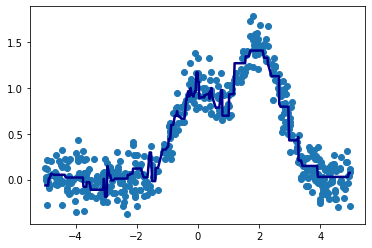

In [ ]:
regressor = BoostedRegressTree()
regressor.fit(reg_X_train, reg_y_train, trees=5, eta=0.6, random_state=24)

train_pred = regressor.predict(reg_X_train)
valid_pred = regressor.predict(reg_X_valid)
print(Metrics.R2(train_pred, reg_y_train))
print(Metrics.R2(valid_pred, reg_y_valid))

plt.scatter(reg_X, reg_y)
plt.plot(reg_X, regressor.predict(reg_X), color='darkblue', lw=2.5)
plt.show()

# boosted random forest test

In [ ]:
classifier = ClassRandomForest(basic_tree_class=BoostedClassTree)
cl_oob = classifier.fit(cl_X_train, cl_y_train, max_depth=3, boost=10, random_state=24)

train_pred = classifier.predict(cl_X_train)
valid_pred = classifier.predict(cl_X_valid)
print(f'OOB = {cl_oob}')
print(Metrics.f1_score(train_pred, cl_y_train))
print(Metrics.f1_score(valid_pred, cl_y_valid))

OOB = 5.8817234158062455
0.9884393063583815
0.9605263157894737


OOB = 8.930237456145951
0.9128489532048317
0.9192801452377286


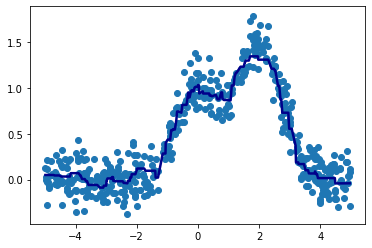

In [ ]:
regressor = RegressRandomForest(basic_tree_class=BoostedRegressTree)
reg_oob = regressor.fit(reg_X_train, reg_y_train, max_depth=9, eta=0.85,
                        boost_metric=Metrics.R2, boost_data=(reg_X_train, reg_y_train), random_state=24)
# reg_oob = regressor.fit(reg_X_train, reg_y_train, max_depth=9, boost_metric=Metrics.R2, boost_data=(reg_X_train, reg_y_train), random_state=24)

train_pred = regressor.predict(reg_X_train)
valid_pred = regressor.predict(reg_X_valid)
print(f'OOB = {reg_oob}')
print(Metrics.R2(train_pred, reg_y_train))
print(Metrics.R2(valid_pred, reg_y_valid))

plt.scatter(reg_X, reg_y)
plt.plot(reg_X, regressor.predict(reg_X), color='darkblue', lw=2.5)
plt.show()

# decision tree with linear leaf

In [ ]:
lenclassifier = ClassDecisionTree(predictor=Predictor().class_linear)
lenclassifier.fit(cl_X_train, cl_y_train, min_samples_leaf=2)

train_pred = lenclassifier.predict(cl_X_train)
valid_pred = lenclassifier.predict(cl_X_valid)
print(Metrics.f1_score(train_pred, cl_y_train))
print(Metrics.f1_score(valid_pred, cl_y_valid))

0.9801699716713881
0.9240506329113924


0.9053989451722839
0.9095449362566004


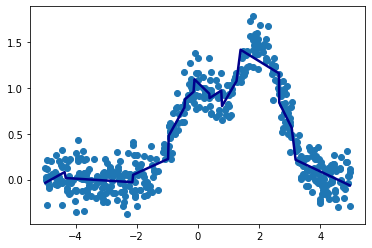

In [ ]:
linregressor = RegressDecisionTree(predictor=Predictor().regress_linear)
linregressor.fit(reg_X_train, reg_y_train, min_samples_leaf=11)

train_pred = linregressor.predict(reg_X_train)
valid_pred = linregressor.predict(reg_X_valid)
print(Metrics.R2(train_pred, reg_y_train))
print(Metrics.R2(valid_pred, reg_y_valid))

plt.scatter(reg_X, reg_y)
plt.plot(reg_X, linregressor.predict(reg_X), color='darkblue', lw=2.5)
plt.show()

# random forest with linear leaf

In [ ]:
classifier = ClassRandomForest(basic_tree_params={'criteria': Criteria.entropy, 'predictor': Predictor(11).class_linear})
cl_oob = classifier.fit(cl_X_train, cl_y_train,
                        min_samples_leaf=5, random_state=24)

train_pred = classifier.predict(cl_X_train)
valid_pred = classifier.predict(cl_X_valid)
print(f'OOB = {cl_oob}')
print(Metrics.f1_score(train_pred, cl_y_train))
print(Metrics.f1_score(valid_pred, cl_y_valid))

OOB = 47.47018100895794
0.9558011049723757
0.9125


OOB = 8.515633312239903
0.9057629533513541
0.9071567565087798


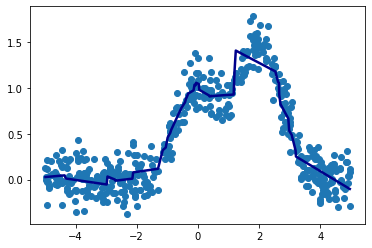

In [ ]:
regressor = RegressRandomForest(basic_tree_params={'predictor': Predictor(11).regress_linear})
reg_oob = regressor.fit(reg_X_train, reg_y_train,                        
                        min_samples_leaf=12, random_state=24)

train_pred = regressor.predict(reg_X_train)
valid_pred = regressor.predict(reg_X_valid)
print(f'OOB = {reg_oob}')
print(Metrics.R2(train_pred, reg_y_train))
print(Metrics.R2(valid_pred, reg_y_valid))

plt.scatter(reg_X, reg_y)
plt.plot(reg_X, regressor.predict(reg_X), color='darkblue', lw=2.5)
plt.show()

# boosted decision tree with linear leaf

In [ ]:
classifier = BoostedClassTree(basic_tree_params={'criteria': Criteria.entropy, 'predictor': Predictor(11).class_linear})
classifier.fit(cl_X_train, cl_y_train,
               min_samples_leaf=7, random_state=24)

train_pred = classifier.predict(cl_X_train)
valid_pred = classifier.predict(cl_X_valid)
print(Metrics.f1_score(train_pred, cl_y_train))
print(Metrics.f1_score(valid_pred, cl_y_valid))

0.98567335243553
0.9419354838709678


0.9148364305895316
0.9133399555703023


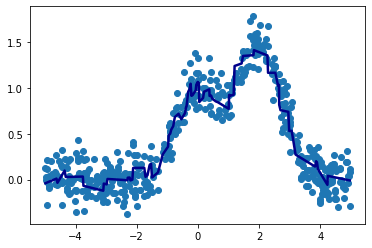

In [ ]:
regressor = BoostedRegressTree(basic_tree_params={'predictor': Predictor(11).regress_linear})
regressor.fit(reg_X_train, reg_y_train,
              min_samples_leaf=10, trees=5, eta=0.6, random_state=24)

train_pred = regressor.predict(reg_X_train)
valid_pred = regressor.predict(reg_X_valid)
print(Metrics.R2(train_pred, reg_y_train))
print(Metrics.R2(valid_pred, reg_y_valid))

plt.scatter(reg_X, reg_y)
plt.plot(reg_X, regressor.predict(reg_X), color='darkblue', lw=2.5)
plt.show()

# boosted random forest with linear leaf

In [ ]:
classifier = ClassRandomForest(basic_tree_class=BoostedClassTree,
                               basic_tree_params={'criteria': Criteria.entropy, 'predictor': Predictor(11).class_linear})
cl_oob = classifier.fit(cl_X_train, cl_y_train,
                        min_samples_leaf=5, random_state=24)

train_pred = classifier.predict(cl_X_train)
valid_pred = classifier.predict(cl_X_valid)
print(f'OOB = {cl_oob}')
print(Metrics.f1_score(train_pred, cl_y_train))
print(Metrics.f1_score(valid_pred, cl_y_valid))

OOB = 6.907257717854829
0.9913544668587896
0.954248366013072


OOB = 8.627597572687256
0.9115034477911588
0.9207124278710586


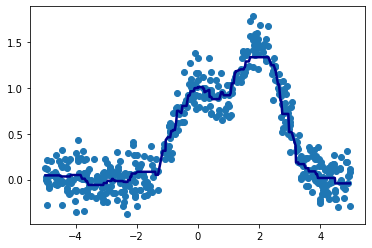

In [ ]:
regressor = RegressRandomForest(basic_tree_class=BoostedRegressTree,
                                basic_tree_params={'predictor': Predictor(11).regress_linear})
reg_oob = regressor.fit(reg_X_train, reg_y_train,
                        eta=0.85, min_samples_leaf=12, random_state=24)

train_pred = regressor.predict(reg_X_train)
valid_pred = regressor.predict(reg_X_valid)
print(f'OOB = {reg_oob}')
print(Metrics.R2(train_pred, reg_y_train))
print(Metrics.R2(valid_pred, reg_y_valid))

plt.scatter(reg_X, reg_y)
plt.plot(reg_X, regressor.predict(reg_X), color='darkblue', lw=2.5)
plt.show()